# IBM Data Science Professional Certificate
## Captsone project
This notebook will be used for the various assignments of the Coptsone project of IBM Data Science Professional Certificate on Coursera. It will use the Belgian road accident database between 2005 and 2019 to build an accident severity predictors algorithm.

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns

## Data importing & cleaning

In [34]:
#Loading full dataset
df_full = pd.read_csv('data/Belgium_Road_Accident.csv')

In [35]:
#Keeping only the interesting columns
df = df_full[['DT_DAY','DT_HOUR','CD_DAY_OF_WEEK','CD_BUILD_UP_AREA',\
              'CD_VICT_TYPE','CD_ROAD_USER_TYPE','CD_AGE_CLS','CD_SEX',\
              'CD_ROAD_TYPE','CD_LIGHT_COND',\
              'TX_MUNTY_DESCR_FR',\
              'MS_SLY_INJ','MS_SERLY_INJ','MS_DEAD_30_DAYS']].copy()

#Renaming the columns for convenience
df.columns = ['Day','Hour','DOW','Area','Victim','Vehicle','Age','Sex',\
                    'Road','Light','City','Slight','Severe','Death']

#Convcerting date into month
df['Day'] = pd.DatetimeIndex(df['Day']).month
df.rename(columns={'Day':'Month'}, inplace=True)
#Converting city into categories
codes = df['City'].astype('category').cat.codes
df.loc[:,'City']=codes

original = df.shape[0]

In [36]:
#Removing entires with missing infomration
df.drop(df[df['Hour']==99].index,inplace=True)
df.drop(df[df['Area']==9].index,inplace=True)
df.drop(df[df['Area']==0].index,inplace=True)
df.drop(df[df['Victim']==9].index,inplace=True)
df.drop(df[df['Vehicle']==99].index,inplace=True)
df.drop(df[df['Age']==999].index,inplace=True)
df.drop(df[df['Sex']==9].index,inplace=True)
df.drop(df[df['Road']==9].index,inplace=True)
df.drop(df[df['Light']==0].index,inplace=True)
df.drop(df[df['Light']==9].index,inplace=True)

#Light type 5 is means that street light was present but nto turned on ==> assimilated to type 4, street light no present
df.loc[df[df['Light']==5].index,'Light'] = 4

removed = (original - df.shape[0])/original
print(str(round(removed * 100))+'% of the entries have been removed due to incomplete data.')
print(str(df.shape[0])+' entries remain for analysis')

13% of the entries have been removed due to incomplete data.
734301 entries remain for analysis


In [37]:
#Creating accident severity columns:
    #If only slightly injured, severity = 1
    #If at least 1 severly injured, severity = 2
    #If at least 1 death, severity = 3
df['sev'] = 0
df.loc[df['Severe']>0,'sev'] = 1
df.loc[df['Death']>0,'sev'] = 2


In [38]:
#Define catergory (translation from the raw data)
Month = ['Jan','Feb','March','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
Hour = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
DOW = ['Monday','Tuseday','Wednesday','Thursday','Friday','Saturday','Sunday']
Area = ['In_city','Out_city']
Victim = ['Driver','Passenger','Pedestrian','Other','Cyclist','Motorcyclist','Moped_rider']
Age = ['0to4','5to9','10to14','15to19','20to24','25to29','30to34','35to39','40to44','45to49',\
      '50to54','55to59','60to64','65to69','70to74','75more']
Sex = ['Male','Female']
Road = ['Highway','Main_road','Secondary_road']
Light = ['Daylight','Sunrise_sunset','Night_LightOn','Night_LightOFF']


## Data analysis

In [39]:
from matplotlib import pyplot as plt

In [40]:
df.describe()

,Month,Hour,DOW,Area,Victim,Vehicle,Age,Sex,Road,Light,City,Slight,Severe,Death,sev
count,734301.000000,734301.000000,734301.000000,734301.000000,734301.000000,734301.000000,734301.000000,734301.000000,734301.000000,734301.000000,734301.000000,734301.000000,734301.000000,734301.000000,734301.000000
mean,6.634590,13.269757,4.013632,1.461620,2.701937,7.651223,7.879148,1.414842,2.306102,1.613156,272.170451,0.908999,0.092692,0.015648,0.123003
std,3.357199,5.521180,1.962270,0.498525,2.043087,8.240797,3.635202,0.492695,0.633486,0.945822,179.033655,0.346251,0.292428,0.124742,0.372852
min,1.000000,0.000000,1.000000,1.000000,1.000000,-8.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,9.000000,2.000000,1.000000,1.000000,1.000000,5.000000,1.000000,2.000000,1.000000,103.000000,1.000000,0.000000,0.000000,0.000000
50%,7.000000,14.000000,4.000000,1.000000,2.000000,2.000000,7.000000,1.000000,2.000000,1.000000,263.000000,1.000000,0.000000,0.000000,0.000000
75%,10.000000,17.000000,6.000000,2.000000,5.000000,16.000000,10.000000,2.000000,3.000000,3.000000,423.000000,1.000000,0.000000,0.000000,0.000000
max,12.000000,23.000000,7.000000,2.000000,7.000000,28.000000,16.000000,2.000000,3.000000,4.000000,595.000000,25.000000,7.000000,3.000000,2.000000


Max and min of all feature are within the expected limites (e.g. hour between 0 and 23)

In [41]:
df.corr()

,Month,Hour,DOW,Area,Victim,Vehicle,Age,Sex,Road,Light,City,Slight,Severe,Death,sev
Month,1.000000,0.008593,0.001278,-0.005268,0.021377,0.017607,0.003045,0.002532,0.001015,0.055932,-0.001119,0.000526,-0.001378,-0.000554,-0.001441
Hour,0.008593,1.000000,-0.045781,-0.034605,0.059538,0.048848,0.010885,0.028430,0.037765,-0.025392,-0.006921,0.013775,-0.014414,-0.018244,-0.022516
DOW,0.001278,-0.045781,1.000000,0.040160,-0.052644,-0.079354,-0.023481,-0.037430,-0.009372,0.119644,0.014160,-0.019703,0.027485,0.015391,0.030934
Area,-0.005268,-0.034605,0.040160,1.000000,-0.243762,-0.313547,0.016980,-0.025999,-0.387320,0.061952,0.085680,-0.065440,0.065403,0.058207,0.088777
Victim,0.021377,0.059538,-0.052644,-0.243762,1.000000,0.755312,-0.037485,-0.132046,0.205974,-0.158693,-0.020034,-0.069700,0.069281,-0.004490,0.051968
Vehicle,0.017607,0.048848,-0.079354,-0.313547,0.755312,1.000000,0.016908,-0.088349,0.245461,-0.165816,-0.028101,-0.084895,0.075946,0.006012,0.064792
Age,0.003045,0.010885,-0.023481,0.016980,-0.037485,0.016908,1.000000,0.037358,-0.004695,-0.102301,0.010827,-0.100789,0.059263,0.049981,0.081268
Sex,0.002532,0.028430,-0.037430,-0.025999,-0.132046,-0.088349,0.037358,1.000000,-0.002533,-0.097862,0.002703,0.066645,-0.056144,-0.045613,-0.074007
Road,0.001015,0.037765,-0.009372,-0.387320,0.205974,0.245461,-0.004695,-0.002533,1.000000,-0.061431,-0.017841,0.011501,-0.010465,-0.032746,-0.028975
Light,0.055932,-0.025392,0.119644,0.061952,-0.158693,-0.165816,-0.102301,-0.097862,-0.061431,1.000000,0.003307,-0.045795,0.044354,0.048708,0.065758


The only correlation the appear significant is a 0.755 correlation between vehicule type (car, bike, motorbike,...) and victime type (driver, passenger, pedestrian,...). This is to totally expected and we could consider tropping the "Vehicle" feature as it doesn't bring much additional information.
Other low correlations can be seen between Area and Vehicle and Area and Road. Agin undestandable as highways and motored vehicle like car and trucks are more frequently found outside cities. However in this case the correlation is small and it is worth keeping all three attributes.
Other features seems not correlated at all. It can also

In [42]:
df.drop(columns='Vehicle',inplace=True)

There is much more accidents where people are only slightly injured. And only a handfull of accident lead to death. This is fortunate for road user, but something to watch out for here. We've an unballenced/skewed dataset and need to be careful about this.

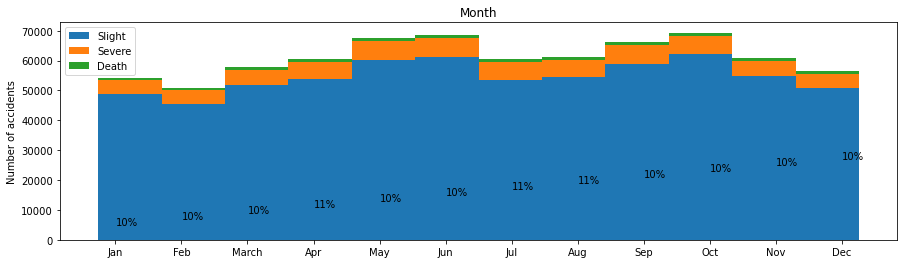

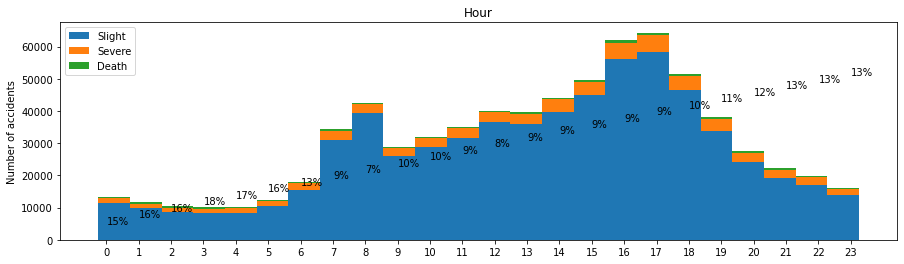

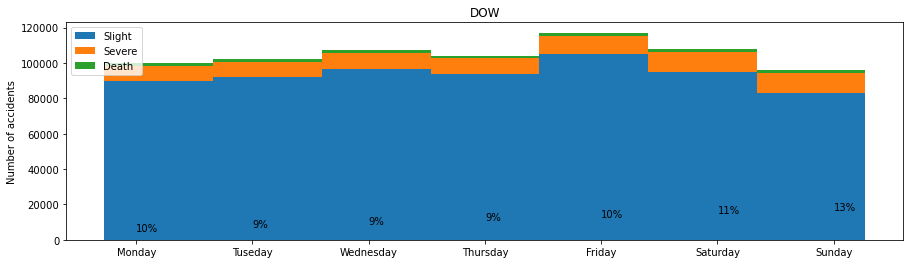

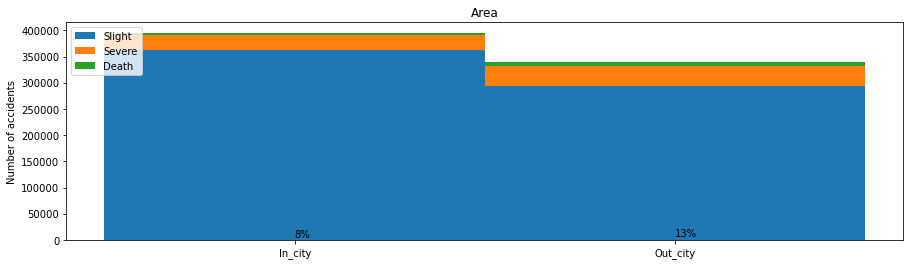

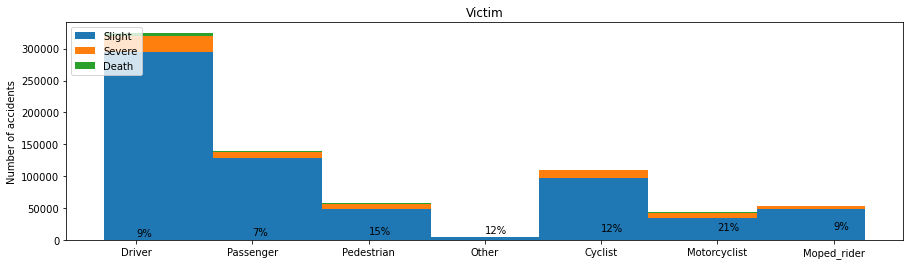

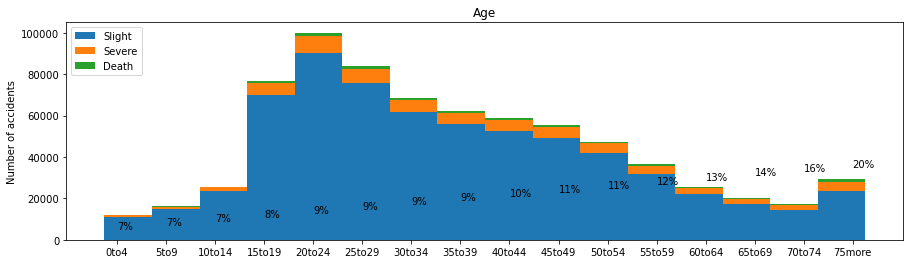

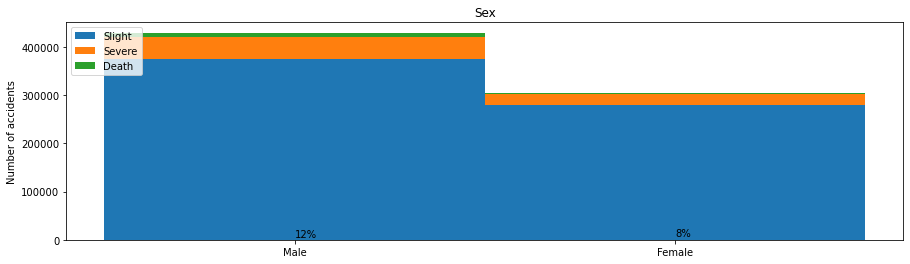

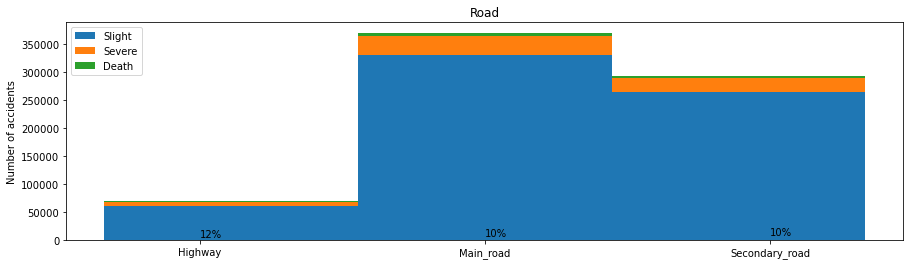

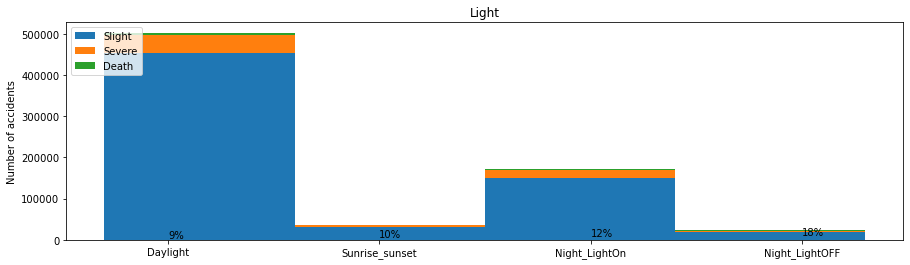

In [43]:
feat = ['Month','Hour','DOW', 'Area', 'Victim', 'Age', 'Sex', 'Road', 'Light']
names = [Month,Hour, DOW, Area, Victim, Age, Sex, Road, Light]
for idf,f in enumerate(feat):
    cat = df[f].unique()
    b = len(cat)
    p,a = plt.subplots(1,figsize=(15,4))
    h = a.hist([df.loc[df['sev']==0,f],df.loc[df['sev']==1,f],df.loc[df['sev']==2,f]],\
             bins=b, stacked=True, label=['Slight','Severe','Death'],align='mid')
    plt.title(f)
    plt.ylabel('Number of accidents')
    res = h[0]
    res[2] = res[2]-res[1]
    res[1] = res[1]-res[0]
    prop = sum(res[1:])/sum(res)
    a.legend(loc='upper left')
    rng = np.linspace(min(cat)+0.25,max(cat)-0.25,b)
    a.set_xticks(rng)
    a.set_xticklabels(names[idf])
    for ids,s in enumerate(prop):
        a.text(rng[ids],5000+2000*ids,str(int(s*100))+'%')

The number displayed on the plot is the ratio of sever + deathly accident over the total number of accident. The larger this ratio, the more sever accidents are.
More accident occurs during the day, but night accidents are more sever
Accidents are spread out over the entire week, with maybe a slight increase on Friday, but accident are more sever on Sunday (Sunday drivers?)
Accident is cities are more frequent but less sever than outside cities.
Most victimes are drivers or passenger, but they are most of the time not severly injured. Motorcyclsit are the most vulnerabel people on the road as their accident results more frequently in sever injuries or death. Followed by pedestrains.
Young adults are the most frequent victims. But the older you get, the worth the consequence of road accident appears to be.
Male do more accidents are are more severly injured than women.
Significantly less accident happen on the highway but they seem to be slightly more sever.
Night accident, especially when the light is out are much worth the day accidents.


## Severity predictor

### Data preparation

In [44]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split as tts
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler, TomekLinks

import sklearn
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix


0    0.892570
1    0.091857
2    0.015573
Name: sev, dtype: float64
0    655415
1     67451
2     11435
Name: sev, dtype: int64


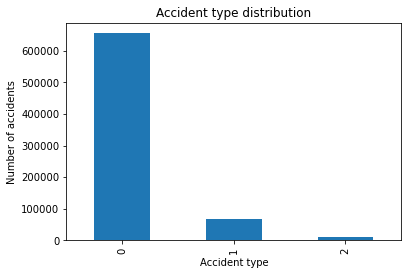

In [45]:
severity = df['sev'].value_counts()
severity.plot(kind='bar')
plt.title('Accident type distribution')
plt.xlabel('Accident type')
plt.ylabel('Number of accidents')

print(severity/sum(severity))
print(severity)

y_full = df['sev'].values
Xdf = df.drop(columns=['Slight','Severe','Death','sev'])
X_full = Xdf.values

# Scaling
scaler = preprocessing.StandardScaler().fit(X_full)
X_scale= scaler.transform(X_full)


#df_slight = df[df['sev']==0].sample(n=n, replace=True, random_state=1)
#df_sev = df[df['sev']==1].sample(n=n, replace=True, random_state=1)
#df_death = df[df['sev']==2].sample(n=n, replace=True, random_state=1)
#df_red = result = pd.concat([df_slight,df_sev,df_death]).sample(frac=1).reset_index()

(array([13108.,  6745.,  2287.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

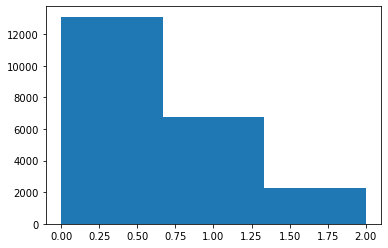

In [46]:
randomSampler = RandomUnderSampler(sampling_strategy={0:int(severity[0]/50),1:int(severity[1]/10),2:int(severity[2]/5)},random_state=10)
X_red, y_red = randomSampler.fit_sample(X_scale, y_full)
plt.hist(y_red, bins=3)

(array([2287., 2287., 2287.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

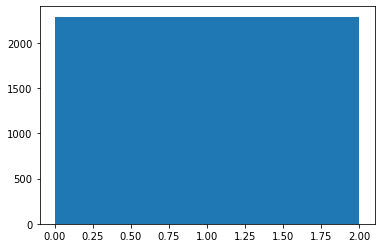

In [47]:
sampler = ClusterCentroids(sampling_strategy='not minority')
X, y = sampler.fit_sample(X_red, y_red)
plt.hist(y, bins=3)

In [48]:
X_train,X_test,y_train,y_test = tts(X,y, test_size=0.2, random_state=4)
feature_names = Xdf.columns.values
target = ['Slight','Sever','Death']
print(X.shape,y.shape)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(6861, 10) (6861,)
(5488, 10) (1373, 10)
(5488,) (1373,)


In [49]:
from itertools import product
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Decision tree

In [50]:
#!pip install pydotplus
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from six import StringIO
from matplotlib import pyplot as plt
import pydotplus
import matplotlib.image as mpimg

In [51]:
rng = range(1,21)
param = {'max_depth':rng,
         'criterion':('gini','entropy')}
tree = DecisionTreeClassifier(class_weight ={0:1,1:1,2:1})
clf = GridSearchCV(tree, param, scoring='f1_macro', n_jobs=-1, cv=5)
clf.fit(X_train,y_train)
print('Best parameters found:\n', clf.best_params_)
print(clf.best_score_)
print(clf.cv)
best_tree = clf.best_estimator_

Best parameters found:
 {'criterion': 'entropy', 'max_depth': 14}
0.5426814360376934
5


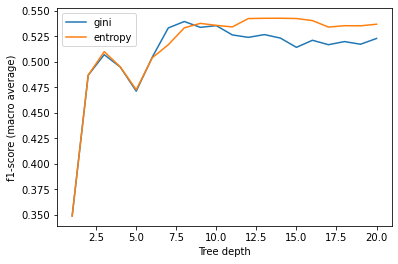

In [52]:
plt.plot(rng,clf.cv_results_['mean_test_score'][0:len(rng)],label = 'gini')
plt.plot(rng,clf.cv_results_['mean_test_score'][len(rng):2*len(rng)],label = 'entropy')
plt.xlabel('Tree depth')
plt.ylabel('f1-score (macro average)')
plt.legend()

              precision    recall  f1-score   support

      Slight       0.59      0.54      0.57       454
       Sever       0.43      0.38      0.40       449
       Death       0.63      0.75      0.68       470

    accuracy                           0.56      1373
   macro avg       0.55      0.56      0.55      1373
weighted avg       0.55      0.56      0.55      1373



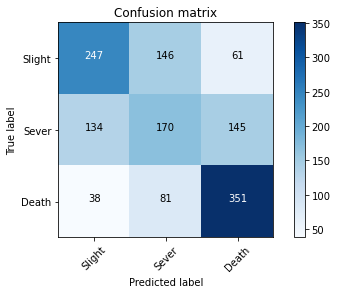

In [53]:
Tree_yhat = best_tree.predict(X_test)
print(classification_report(y_test, Tree_yhat, target_names=target))

Tree_confusion = confusion_matrix(y_test,Tree_yhat)
plot_confusion_matrix(Tree_confusion,target)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.588996 to fit



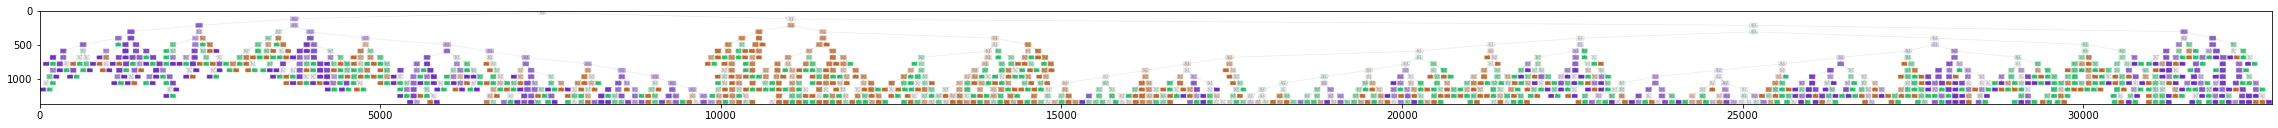

In [54]:
dot_data = StringIO()
file = 'tree.png'

export_graphviz(best_tree,feature_names = feature_names, out_file = dot_data,\
             class_names = target, filled = True, special_characters=False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(file)
img = mpimg.imread(file)
plt.figure(figsize=(40,20))
plt.imshow(img)

Unweighted avergage f1-score is used to select to optimal tree depth. We do see that increasign the depth improves accuracy (according to this criteria) up to around 8 levels deep. Increasing the depth further seems to slightly reduce the accuracy.
The accuracy of the prediction seems no very high, especially when prediciting accidents leading to severe injuries. This might be because the features of such accident are between non-severe and deathly and it might be difficult to clearly make a distiction.

### K Nearest Neighbour

In [55]:
from sklearn.neighbors import KNeighborsClassifier

In [56]:
param = {'n_neighbors':range(1,5),
        'weights':('uniform', 'distance'),
        'p':[1,2]}

KNN = KNeighborsClassifier(algorithm='brute')
clf = GridSearchCV(KNN, param, scoring='f1_macro', n_jobs=-1, cv=5)
clf.fit(X_train,y_train)
print('Best parameters found:\n', clf.best_params_)
print(clf.best_score_)
best_KNN = clf.best_estimator_

Best parameters found:
 {'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
0.33883365565615414


              precision    recall  f1-score   support

      Slight       0.31      0.36      0.33       454
       Sever       0.21      0.18      0.20       449
       Death       0.45      0.44      0.45       470

    accuracy                           0.33      1373
   macro avg       0.32      0.33      0.33      1373
weighted avg       0.33      0.33      0.33      1373



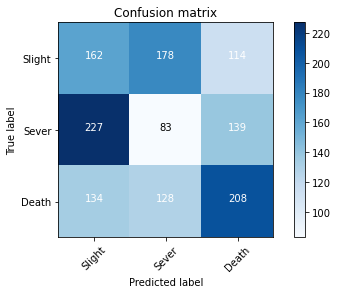

In [57]:
KNN_yhat = best_KNN.predict(X_test)
print(classification_report(y_test, KNN_yhat, target_names=target))

KNN_confusion = confusion_matrix(y_test,KNN_yhat)
plot_confusion_matrix(KNN_confusion,target)

### Support Vector Machine

In [58]:
from sklearn import svm

In [59]:
param = {'C':np.logspace(-3,1,5),
        'kernel':('linear', 'poly', 'rbf', 'sigmoid')}

SVM = svm.SVC()
clf = GridSearchCV(SVM, param, scoring='f1_macro', n_jobs=-1, cv=5)
clf.fit(X_train,y_train)
print('Best parameters found:\n', clf.best_params_)
print(clf.best_score_)
best_SVM = clf.best_estimator_

Best parameters found:
 {'C': 0.1, 'kernel': 'rbf'}
0.44254686959064493


[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
              precision    recall  f1-score   support

      Slight       0.47      0.43      0.45       454
       Sever       0.38      0.34      0.36       449
       Death       0.47      0.56      0.51       470

    accuracy                           0.45      1373
   macro avg       0.44      0.44      0.44      1373
weighted avg       0.44      0.45      0.44      1373



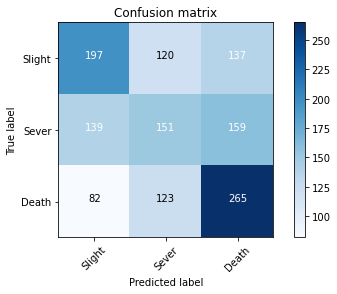

In [60]:
print(np.logspace(-3,1,5))
SVM_yhat = best_SVM.predict(X_test)
print(classification_report(y_test, SVM_yhat, target_names=target))

SVM_confusion = confusion_matrix(y_test,SVM_yhat)
plot_confusion_matrix(SVM_confusion,target)

### Logisitic regression

In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
LR = LogisticRegression()

param = {'C':np.logspace(-3,1,5),
        'solver':('newton-cg', 'lbfgs', 'sag', 'saga'),
        'multi_class':('ovr', 'multinomial')}
clf = GridSearchCV(LR, param, scoring = 'f1_macro', n_jobs=1, cv=5)
clf.fit(X_train,y_train)
print('Best parameters found:\n', clf.best_params_)
print(clf.best_score_)
best_LR = clf.best_estimator_


Best parameters found:
 {'C': 0.1, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.4398512111582102


              precision    recall  f1-score   support

      Slight       0.45      0.49      0.47       454
       Sever       0.40      0.30      0.34       449
       Death       0.47      0.54      0.50       470

    accuracy                           0.45      1373
   macro avg       0.44      0.45      0.44      1373
weighted avg       0.44      0.45      0.44      1373



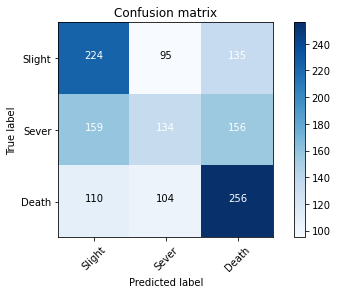

In [63]:
LR_yhat = best_LR.predict(X_test)
print(classification_report(y_test, LR_yhat, target_names=target))

LR_confusion = confusion_matrix(y_test,LR_yhat)
plot_confusion_matrix(LR_confusion,target)